## COMP41680 Assignment 1

Name: Li Weijing  
Student No.: 19204246

In [1]:
# -*- coding: UTF-8 -*-
import requests
import csv
import bs4
import pandas as pd
import urllib.request

import sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import cross_val_score,KFold,train_test_split
from sklearn import metrics,ensemble

import nltk
from tqdm import tqdm
import math
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

## Tasks 1: Collect and store review categories

In [2]:
'''
collect_url: Collect all text-reviews from the subpage of path, store the review 
text and a class label ('negative' and 'positive').
'''
def collect_url(path):
    df_sub = pd.DataFrame([], columns=['review-text', 'rating'])
    response= urllib.request.urlopen(path)
    html = response.read().decode()
    parser = bs4.BeautifulSoup(html,"html.parser")
    url_list = []
    for match in parser.find_all("a"):
        text = match.get('href')
        url_list.append(text)
    ii=1
    for i in tqdm(url_list):
        path = "http://mlg.ucd.ie/modules/yalp/"+i
        response= urllib.request.urlopen(path)
        html = response.read().decode()
        parser = bs4.BeautifulSoup(html,"html.parser")
        for match in parser.find_all("p"):
            text = str(match.get_text)
            if "class=\"rating\"" in text:
                start_pos = text.find("class=\"rating\"")+len("class=\"rating\"><img alt=\"")
                rating = int(text[start_pos:start_pos+1])
                if rating<=3:
                    df_sub.loc[ii,'rating']="negative"
                elif rating>=4:
                    df_sub.loc[ii,'rating']="positive"
            if "class=\"review-text\"" in text:
                start_pos = text.find("class=\"review-text\"")+len("class=\"review-text\"")+1
                df_sub.loc[ii,'review-text']=text[start_pos:-5]
                ii+=1
    return df_sub

In [3]:
df_sub_one = collect_url("http://mlg.ucd.ie/modules/yalp/cafes_list.html")
df_sub_one.to_csv("reviews_cafes.csv",index=True)
df_sub_two = collect_url("http://mlg.ucd.ie/modules/yalp/hotels_list.html")
df_sub_two.to_csv("reviews_hotels.csv",index=True)
df_sub_three = collect_url("http://mlg.ucd.ie/modules/yalp/restaurants_list.html")
df_sub_three.to_csv("reviews_restaurants.csv",index=True)

100%|███████████████████████████████████████████████████████| 101/101 [01:06<00:00,  1.51it/s]


## Task 2a. Create a numeric representation of the data

In [4]:
df_one = pd.read_csv("reviews_cafes.csv", sep=",")
df_two = pd.read_csv("reviews_hotels.csv", sep=",")
df_three = pd.read_csv("reviews_restaurants.csv", sep=",")
df=pd.concat([df_one,df_two,df_three])
df.head(5)

,Unnamed: 0,review-text,rating
0,1,Pros: Lots of items you would not expect from ...,positive
1,2,Best egg-tarts in town! There's really not muc...,positive
2,3,I've been to ABC Bakery a few times since I re...,negative
3,4,"FYI, Closed Monday's New ownership for about 1...",negative
4,5,The inside may not look like much but they mak...,positive


In [5]:
review_document = df["review-text"]
rating = df["rating"]

In [6]:
def lemma_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_tokens = []
    for token in tokens:
        lemma_tokens.append( lemmatizer.lemmatize(token) )
    return lemma_tokens

In [7]:
vectorizer = TfidfVectorizer( min_df = 10, stop_words="english",tokenizer=lemma_tokenizer)
X = pd.DataFrame(vectorizer.fit_transform(review_document).toarray())

In [8]:
# divide X into three parts: cafe, hotel and restaurant
X_one = X[:df_one.shape[0]]
y_one = rating[:df_one.shape[0]]

X_two = X[df_one.shape[0]:(df_one.shape[0]+df_two.shape[0])]
y_two = rating[df_one.shape[0]:(df_one.shape[0]+df_two.shape[0])]

X_three = X[-df_three.shape[0]:]
y_three = rating[-df_three.shape[0]:]

In [9]:
print(X_one.shape,y_one.shape,X_two.shape,y_two.shape,X_three.shape,y_three.shape)

(2000, 3362) (2000,) (2000, 3362) (2000,) (2000, 3362) (2000,)


## Task 2b. Build a classification model ：Random Forests

In [10]:
# Use random forest to build a classification model
my_model = ensemble.RandomForestClassifier(n_estimators=300)

## Task 2c. Test the predictions of the classification model 

In [11]:
# transform 'negative' and 'positive' to [0,1]
num_classes = 2
y_encoder = sklearn.preprocessing.LabelEncoder()
y_num = y_encoder.fit_transform(rating)

In [12]:
# split data into train dataset and validation dataset
X_train, X_valid, y_train, y_valid \
    = train_test_split(X,y_num,random_state=0,train_size = 0.75)
my_model.fit(X_train,y_train)
y_pred = my_model.predict(X_valid)
# Evaluate simple train and validation dataset
accuracy = metrics.accuracy_score(y_valid,y_pred)
print("Accuracy: "+str(accuracy))
print(metrics.classification_report(y_valid, y_pred))

Accuracy: 0.8666666666666667
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       544
           1       0.85      0.95      0.90       956

    accuracy                           0.87      1500
   macro avg       0.88      0.83      0.85      1500
weighted avg       0.87      0.87      0.86      1500



0.9298028704159489


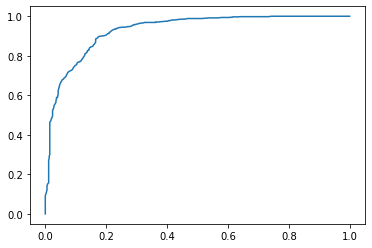

In [13]:
# Make a set of predictions for the validation data
y_pred = my_model.predict_proba(X_valid)
print(metrics.roc_auc_score(y_valid, y_pred[:, 1]))
fpr, tpr, thresh = metrics.roc_curve(y_valid, y_pred[:, 1])
roc_auc = metrics.auc(fpr, tpr)
# Draw the ROC curve for the model
plt.plot(fpr, tpr)

In [14]:
# Cross validation to estimate accuracy
scores = cross_val_score(my_model, X, y_num,cv=10,scoring='accuracy')
print("Mean cross-validation accuracy = %.4f" %scores.mean())

Mean cross-validation accuracy = 0.8590


## Task 3. Train different categories

In [15]:
def train_category(X_train,y_train,X_test,y_test):
    num_classes = 2
    y_encoder = sklearn.preprocessing.LabelEncoder()
    y_train = y_encoder.fit_transform(y_train)
    y_test = y_encoder.fit_transform(y_test)
    
    my_model.fit(X_train,y_train)
    y_pred = my_model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test,y_pred)
    # Use a set of evalution methods to evaluate the model
    print("Accuracy: "+str(accuracy))
    print(metrics.classification_report(y_test, y_pred))
    
    y_pred = my_model.predict_proba(X_test)
    print(metrics.roc_auc_score(y_test, y_pred[:, 1]))
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred[:, 1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr)

Accuracy: 0.79375
              precision    recall  f1-score   support

           0       0.91      0.56      0.69      1662
           1       0.75      0.96      0.84      2338

    accuracy                           0.79      4000
   macro avg       0.83      0.76      0.77      4000
weighted avg       0.82      0.79      0.78      4000

0.8883066770018498


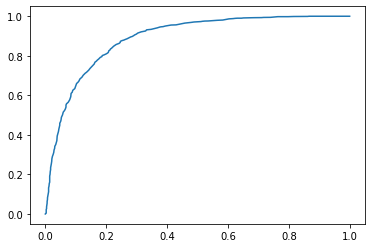

In [16]:
# Train dataset: Category A”.Test dataset Category B and Category C. 
train_category(X_one,y_one,pd.concat([X_two,X_three],axis=0),\
               pd.concat([y_two,y_three],axis=0))

Accuracy: 0.81175
              precision    recall  f1-score   support

           0       0.84      0.56      0.67      1376
           1       0.80      0.95      0.87      2624

    accuracy                           0.81      4000
   macro avg       0.82      0.75      0.77      4000
weighted avg       0.82      0.81      0.80      4000

0.88728984242059


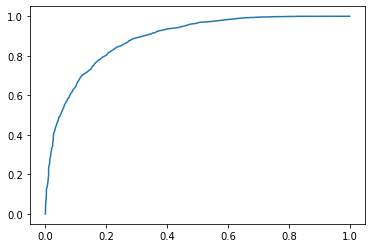

In [17]:
# Train dataset: Category B”.Test dataset Category A and Category C. 
train_category(X_two,y_two,pd.concat([X_one,X_three],axis=0),\
               pd.concat([y_one,y_three],axis=0))

Accuracy: 0.8515
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1362
           1       0.90      0.87      0.89      2638

    accuracy                           0.85      4000
   macro avg       0.83      0.84      0.84      4000
weighted avg       0.85      0.85      0.85      4000

0.9163670526441182


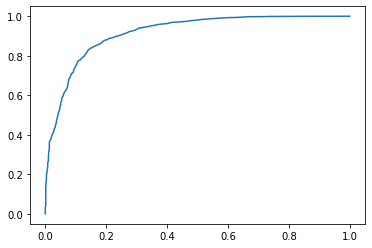

In [18]:
# Train dataset: Category c”.Test dataset Category A and Category B. 
train_category(X_three,y_three,pd.concat([X_one,X_two],axis=0),\
               pd.concat([y_one,y_two],axis=0))

In [19]:
# From the previous evaluation, it's obvious that the model train on category C
# achieves highest accuracy on the test set. The area under the ROC curve also 
# also shows that the third model has the highest accuracy. 